**Alice, Ethan, Cole**

Spring 2020

CS 443: Computational Neuroscience

Project 4: Motion estimation

In [87]:
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from motion_extension_1 import MotionNet,KernelParams, LayerParams, HGateParams
from random_dot_stimulus import make_random_dot_stimulus
from net_plots import vector_sum_plot, plot_act_image_grid



plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The goal of this project/network extension is to create several new layers and see how they affect the network. The first layer we want to add is a mid-range filter between layers 4 and 5. We want to see how that will affect the output of the network overall, particularly in relation to the output of the coherence videos. To test this we will initially set up a full simulation of rightward motion in the overall network as we have done before. The output of the MSTD cells after all was said and done was the following: [1.771 0.001 0.008 0.001 0.    0.001 0.    0.   ]. We will compare against this with our new MRF cell layer. Our hypothesis is that we will get a noisier and worse output. This is because we are diluting the competition layer's output through this excitatory MRF layer. Thus, the input to the fifth layer has less strenght in its feedback as the competition layer's output is made less drastic by the excitatory MRF.

In [88]:
#the following is full network code.
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)

lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)

lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)

lvl4_33_params = LayerParams(tau=5, C=0.5) 
lvl4_33_excit_ker_params = KernelParams(sigma=(7, 1.5), sz=(33, 33), gain=3.5)

lvl5_params = LayerParams(tau=5, C=0.5)
lvl5_excit_ker_params = KernelParams(sigma=(10, 3), sz=(51, 51), gain=2)

lvl6_params = LayerParams(tau=5, C=0.5, excit_g=2)
lvl6_inhib_ker_params = KernelParams(sigma=8, sz=(51, 51), gain=1)



# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                lvl4_33_params = lvl4_33_params,
                lvl4_33_excit_ker_params = lvl4_33_excit_ker_params,
                lvl5_params = lvl5_params,
                lvl5_excit_ker_params = lvl5_excit_ker_params,
                lvl6_params = lvl6_params,
                lvl6_inhib_ker_params = lvl6_inhib_ker_params,
                do_lvl4_67 = False)
net.simulate(right_motion)
# Compute rectified layer output
mstd_out = net.mstd_out





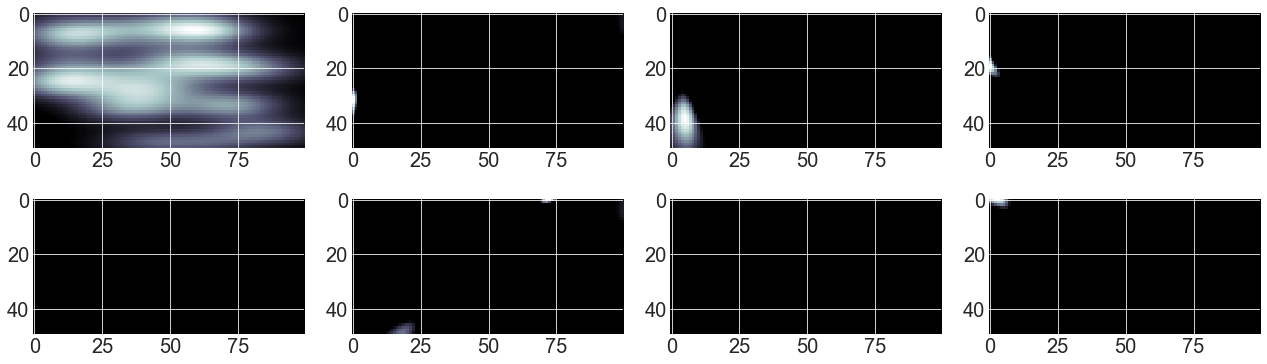

In [89]:
# Your grid of image plots of the layer 6 cells output over time
plot_act_image_grid(mstd_out[::5], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))


In [90]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}\n and used to  look like\n[1.771 0.001 0.008 0.001 0. 0.001 0. 0. ]')

Your decoded evidence for each direction at the end of the simulation is
[1.708 0.    0.009 0.    0.    0.    0.    0.   ]
 and used to  look like
[1.771 0.001 0.008 0.001 0. 0.001 0. 0. ]


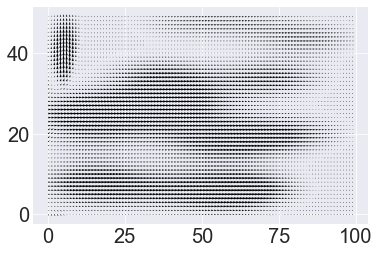

In [91]:
# Your vector sum plot of the layer 6 output over time
vector_sum_plot(mstd_out, figSz=(18, 9), pause=0.01)

The output here was pretty much aligned with our hypothesis that it would get worse, but we expected a worse drop off in performance. We adjusted the parameters such that the output threshold was 0 because we when we had a small threshold, almost everything except our initial direction went to 0 which was not helpful to us. 


For the next layer we are going to add, we are doing a competition layer. Basically, we are recreating the one-two punch of the third and fourth layers with larger kernel sizes. We hypothesize that we will now get an overall improvement. With two competition layers of varying size, we can improve our overall contrast between directions. 

In [79]:
#the following is full network code.
np.random.seed(0)
right_motion = make_random_dot_stimulus(n_frames=10, dir_rc=(0, 1))

# Define parameters
lvl1_params = LayerParams(tau=1, A=1)
lvl1_hgate_params = HGateParams(tau=1, K=50)

lvl2_inter_params = LayerParams(tau=1, excit_g=10, inhib_g=40)
lvl2_params = LayerParams(tau=4, excit_g=10, inhib_g=40, output_thres=0.2)

lvl3_params = LayerParams(tau=0.5, output_thres=0.002) 
lvl3_excit_ker_params = KernelParams(sigma=(2, 0.5), sz=(13, 13), gain=25)

lvl4_params = LayerParams(tau=5, C=0.5)
lvl4_excit_ker_params = KernelParams(sigma=(3, 1), sz=(19, 19), gain=5)
lvl4_inhib_ker_params = KernelParams(sigma=4, sz=(25, 25), gain=5)

lvl4_33_params = LayerParams(tau=5, C=0.5, output_thres=0) 
lvl4_33_excit_ker_params = KernelParams(sigma=(7, 1.5), sz=(33, 33), gain=3.5)

lvl4_67_params = LayerParams(tau=5, C=0.5)
lvl4_67_excit_ker_params = KernelParams(sigma=(7, 1.5), sz=(37, 37), gain=5)
lvl4_67_inhib_ker_params = KernelParams(sigma=4, sz=(43, 43), gain=5)

lvl5_params = LayerParams(tau=5, C=0.5)
lvl5_excit_ker_params = KernelParams(sigma=(10, 3), sz=(51, 51), gain=2)

lvl6_params = LayerParams(tau=5, C=0.5, excit_g=2)
lvl6_inhib_ker_params = KernelParams(sigma=8, sz=(51, 51), gain=1)



# Simulate net
net = MotionNet(dt=0.1, 
                n_dirs=8, 
                lvl1_params=lvl1_params, 
                lv1_hgate_params=lvl1_hgate_params, 
                lvl2_inter_params=lvl2_inter_params, 
                lvl2_params=lvl2_params,
                lvl3_excit_ker_params = lvl3_excit_ker_params,
                lvl3_params = lvl3_params, 
                lvl4_params=lvl4_params, 
                lvl4_excit_ker_params = lvl4_excit_ker_params, 
                lvl4_inhib_ker_params = lvl4_inhib_ker_params,
                lvl4_33_params = lvl4_33_params,
                lvl4_33_excit_ker_params = lvl4_33_excit_ker_params,
                lvl4_67_params = lvl4_67_params,
                lvl4_67_excit_ker_params = lvl4_67_excit_ker_params,
                lvl4_67_inhib_ker_params = lvl4_67_inhib_ker_params,
                lvl5_params = lvl5_params,
                lvl5_excit_ker_params = lvl5_excit_ker_params,
                lvl6_params = lvl6_params,
                lvl6_inhib_ker_params = lvl6_inhib_ker_params)
net.simulate(right_motion)
# Compute rectified layer output
second_mstd_out = net.mstd_out

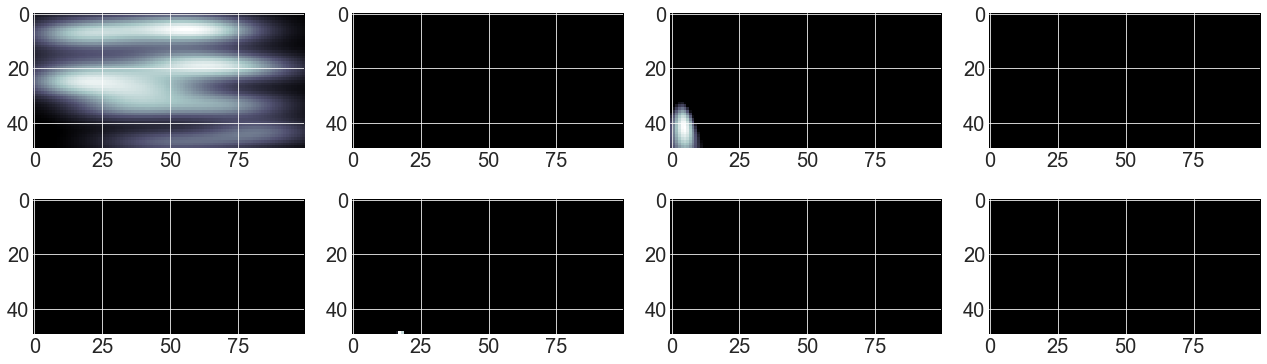

In [72]:
# Your grid of image plots of the layer 6 cells output over time
plot_act_image_grid(second_mstd_out[::5], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))


In [80]:
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}\n and used to  look like\n[1.771 0.001 0.008 0.001 0. 0.001 0. 0. ]')

Your decoded evidence for each direction at the end of the simulation is
[0.822 0.    0.003 0.    0.    0.    0.    0.   ]
 and used to  look like
[1.771 0.001 0.008 0.001 0. 0.001 0. 0. ]


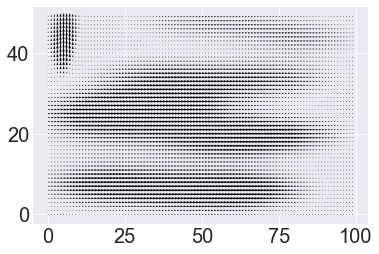

In [92]:
# Your vector sum plot of the layer 6 output over time
vector_sum_plot(second_mstd_out, figSz=(18, 9), pause=0.01)

In [93]:
import time
vids = sio.loadmat('data/coherence_stimuli.mat')
start = time.time()
net.simulate(vids['stimulus_030_coh'])
end = time.time()
plot_act_image_grid(net.mstd_out[::10], n_rows=2, n_cols=4, pause=.00001, cmap='bone', figSz=(18, 9))
print(f'Your decoded evidence for each direction at the end of the simulation is\n{net.decode_direction(net.mstd_cells, -1)}')

print(end - start)

Your decoded evidence for each direction at the end of the simulation is
[0.967 0.003 0.031 0.011 0.    0.001 0.096 0.004]
975.7971611022949


So we have several things to compare here. Our output directions from the original was [1.013 0.007 0.042 0.018 0.    0.005 0.098 0.005]. We have: . Additionally, we can study the time it took to run overall. Our original was 954.85 seconds, or about 20 minutes. This time, it took 975.8 seconds, proving